In [1]:
# Install Dependencies

#!pip install -q gdown supervision
#!pip install inference

In [15]:
import os
os.getcwd()
os.chdir("../03 Data")

In [3]:
DATA_dir = os.getcwd()
print(DATA_dir)

/Users/dgt63/Documents/DGT International/Projects/soccer_video_to_data/03 Data


In [ ]:
#pip install git+https://github.com/roboflow/sports.git

In [ ]:
# download the videos for demos
#!gdown -O "{DATA_dir}/0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
#!gdown -O "{DATA_dir}/2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
#!gdown -O "{DATA_dir}/08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
#!gdown -O "{DATA_dir}/573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
#!gdown -O "{DATA_dir}/121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

## Ball, Players, Goalkeepers, and Referees detection


In [4]:
from inference import get_model
from dotenv import load_dotenv

load_dotenv()
ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/20"
PLAYER_DETECTION_MODEL = get_model(
    model_id=PLAYER_DETECTION_MODEL_ID,
    api_key=ROBOFLOW_API_KEY
)

[11/18/25 12:52:36] WARNING  Your inference package version 0.60.0 is out of date! Please upgrade to __init__.py:41
                             version 0.61.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.To suppress this warning, set QWEN_2_5_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM2_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.To suppress this warning, set CORE_MODEL_GAZE_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support GroundingDINO model. Use pip install 'inference[grounding-d

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 665/666 [04:07<00:00,  2.69it/s]


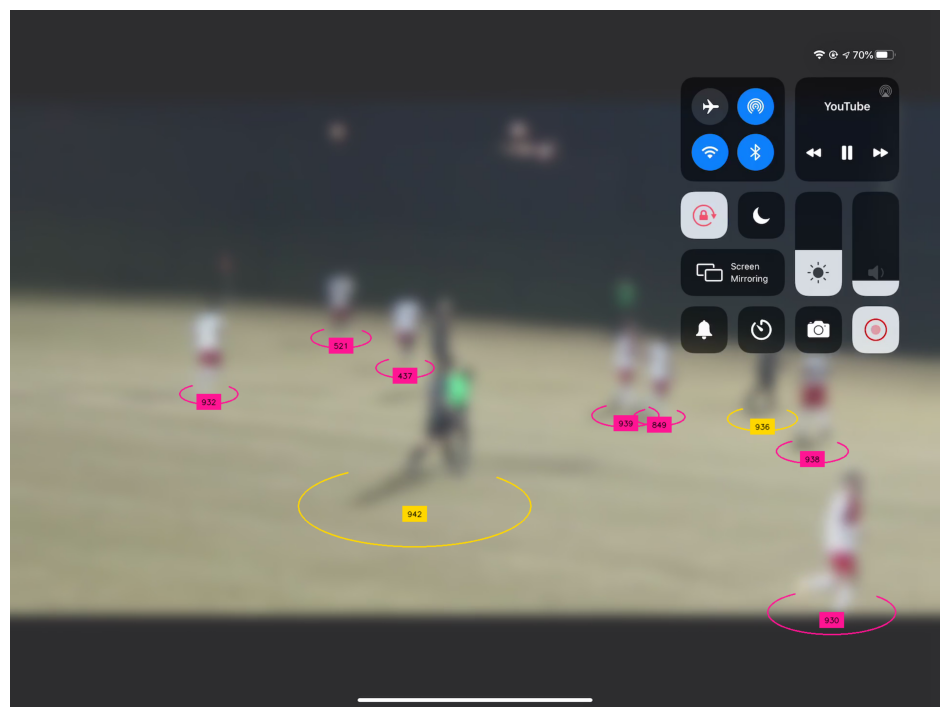

In [18]:
from tqdm import tqdm
import supervision as sv

SOURCE_VIDEO_PATH = f"{DATA_dir}/gtownfc.mp4"
TARGET_VIDEO_PATH = f"{DATA_dir}/gtownfcresults_4.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color = sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness = 2
)

label_annotator = sv.LabelAnnotator(
    color = sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
    
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
                
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
                
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections.class_id = all_detections.class_id - 1
        all_detections = tracker.update_with_detections(all_detections)
                        
        labels = [
        f"{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
        ]
                        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)
        
        video_sink.write_frame(annotated_frame)

sv.plot_image(annotated_frame)

In [6]:
from tqdm import tqdm

STRIDE = 30
PLAYER_ID = 2

def extract_crops(source_video_path: str):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=STRIDE)
    
    crops=[]
    for frame in tqdm(frame_generator, desc='collecting crops'):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id== PLAYER_ID]
        crops += [
            sv.crop_image(frame, xyxy)
            for xyxy
            in detections.xyxy
        ]
    return crops

In [7]:
crops = extract_crops(SOURCE_VIDEO_PATH)

collecting crops: 25it [00:09,  2.73it/s]


In [8]:
len(crops)

499

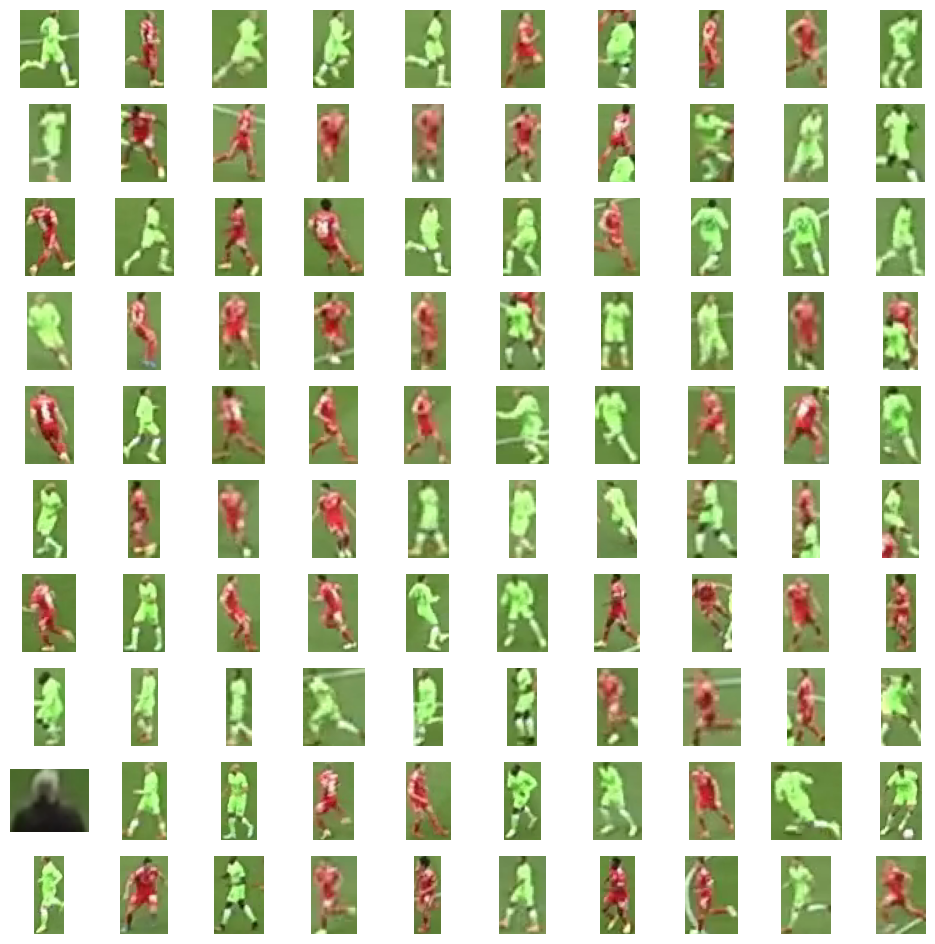

In [9]:
sv.plot_images_grid(crops[:100], grid_size=(10,10))

In [ ]:
# Unfortunately, I dont have enough computing power to useSiglip on my computer so I will use CLIP

#import torch
#from transformers import AutoProcessor, SiglipVisionModel

#SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
#EMBEDDINGS_PRECESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [10]:
from transformers import CLIPProcessor, CLIPModel
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

print(f"Loaded CLIP on {device} safely.")


Loaded CLIP on mps safely.


In [ ]:
#pip install more_itertools

In [13]:
import numpy as np

from more_itertools import chunked

BATCHED_SIZE = 32

crops = [sv.cv2_to_pillow(crops) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []

with torch.no_grad():
    for batch in tqdm(batches, desc='embeddings extraction'):
        inputs = EMBEDDINS_PROCESSOR(images=batch, return_tensors='pt').to(DEVICE)
        outputs = EMBEDDINS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)
                                     

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'
